This is an explanation of how to use the script

In [1]:
# import
from FiLMScope.calibration import (SystemVertexParser, CalibrationInfoManager, SystemCalibrator,
                                   Filmscope_System)
from FiLMScope.util import load_graph_images, load_dictionary, generate_A_matrix
from matplotlib import pyplot as plt 
import matplotlib
import numpy as np

Step 1: Parse Vertices

In [2]:
# set image_folder to the path of the folder with the graph calibration images
# and calibration_filename to the filename where the calibration information will be stored

image_folder = "/media/Friday/Temporary/Clare/FiLMScope_paper_data/calibration_data"
calibration_filename = "delete_calibration_information"

info_manager = CalibrationInfoManager(calibration_filename)

In [19]:
#known information
# spacing between vertices in the calibration graph
info_manager.vertex_spacing_m = 0.004357142857142857
# pixel size for the FiLMScope
info_manager.pixel_size = 1.1e-6

info_manager.save_all_info()

In [20]:
# specify file naming convention for the graph images 
# name_dict just needs to contain a unique portion of the string 
# for the graph images to be used here
num_graphs = 7
name_dict = {}
for i in range(num_graphs):
    name_dict[i] = f"graph_0{i}"

info_manager.plane_names = name_dict

In [21]:
batch_size = 16 
all_planes = np.arange(num_graphs)
all_cam_nums = np.arange(48)

In [ ]:
# load and display an image to manually set the expected spacing
img = load_graph_images(
    folder=image_folder, image_numbers=[all_cam_nums[0]], plane_numbers=[all_planes[0]],
    calibration_filename=calibration_filename
)[all_planes[0]][all_cam_nums[0]]
plt.figure()
plt.imshow(img)
plt.show()

In [ ]:
expected_spacing = int(2410 - 1920)
print(expected_spacing)

In [24]:
# define function to select the plane and camera numbers
# for the next set of images to be processed
# IMPORTANT NOTE: right now the vertex parser has to have
# the same number of cameras in all planes,
# so if we're batching we're only going to do one plane at a time
def get_camera_plane_numbers(batch_size, all_planes, all_cameras):
    info_manager = CalibrationInfoManager(calibration_filename)
    vertices = info_manager.all_vertices

    plane_numbers = []
    camera_numbers = []
    num_images = 0
    chosen_plane = False
    for plane in all_planes:
        if plane not in vertices:
            chosen_plane = True
            camera_numbers = all_cameras[:batch_size]
            plane_numbers.append(plane)
            break
        else:
            cam_vertices = vertices[plane]
            for cam in all_cameras:
                if cam in cam_vertices:
                    continue
                else:
                    chosen_plane = True
                camera_numbers.append(cam)
                num_images = num_images + 1
                if num_images >= batch_size:
                    break
            if chosen_plane:
                plane_numbers.append(plane)
                break
    if not chosen_plane:
        return [-1], [-1]
    return np.asarray(plane_numbers), np.asarray(camera_numbers)

In [25]:
# go through one set of images to ensure parsing settings are working

In [ ]:
plane_numbers, camera_numbers = get_camera_plane_numbers(
    batch_size, all_planes, all_cam_nums
)
if plane_numbers[0] == -1:
    print("Done! All vertices found!")
else:
    print(plane_numbers, camera_numbers)

all_images = load_graph_images(
    folder=image_folder,
    image_numbers=camera_numbers,
    plane_numbers=plane_numbers,
    calibration_filename=calibration_filename
)

parser = SystemVertexParser(
    calibration_filename,
    expected_vertex_spacing=expected_spacing,
    all_images=all_images,
    camera_numbers=camera_numbers,
    plane_numbers=plane_numbers,
    display_downsample=4,
)

In [ ]:
# use this cell to adjust threshold values
# see the README in the calibration folder
# for more info on settings these values  
threshold_values = {
    "adaptive_threshold_range": 491,
    "blur_range": 47,
    "edge_thresh1": 50,
    "edge_thresh2": 200,
    "edge_aperture": 5,
    "line_thresh_per_pixel": 0.08,
}
# threshold_values = None
cam = camera_numbers[0]
plane = plane_numbers[0]
parser.find_lines(
    cam, plane, show=True, show_process=True, threshold_values=threshold_values
)
plt.show()

In [29]:
# when the settings seem reasonable, find the remaining lines
parser.find_all_remaining_lines(show=False, threshold_values=threshold_values)

In [ ]:
# click this cell multiple times until all vertices have been found
# it will show the results for "display_size" results at a time
# to confirm the results are adequate
display_size = 16
parser.find_all_remaining_vertices(show=True, max_display=display_size)

In [42]:
parser.remove_nan_points()
parser.save_all_parameters()
plt.close()

In [ ]:
# once settings are adequate, this cell will do the remaining processing
# to find the vertices for all images
while True:
    plane_numbers, camera_numbers = get_camera_plane_numbers(
        batch_size, all_planes, all_cam_nums
    )
    if plane_numbers[0] == -1:
        print("Done! All vertices found!")
        break
    else:
        print(plane_numbers, camera_numbers)

    all_images = load_graph_images(
        folder=image_folder,
        image_numbers=camera_numbers,
        plane_numbers=plane_numbers,
        calibration_filename=calibration_filename
    )

    parser = SystemVertexParser(
        calibration_filename=calibration_filename,
        expected_vertex_spacing=expected_spacing,
        all_images=all_images,
        camera_numbers=camera_numbers,
        plane_numbers=plane_numbers,
        display_downsample=4,
    )

    parser.find_all_remaining_lines(show=False, max_display=100)
    parser.find_all_remaining_vertices(show=False, max_display=100)
    parser.remove_nan_points()
    parser.save_all_parameters()

This is saying to run the other script to remove extra vertices

to skip those steps, this cell can be uncommented to copy vertices from
the demo calibration file

In [45]:
demo_calibration_filename = image_folder + '/calibration_information_example'
info_manager = CalibrationInfoManager(calibration_filename)
info_manager.all_vertices = load_dictionary(demo_calibration_filename)["all_vertices"]
info_manager.save_all_info()

This is saying to run the script to add alignment points

Can also be skipped by copying from the example

In [46]:
demo_calibration_filename = image_folder + '/calibration_information_example'
info_manager = CalibrationInfoManager(calibration_filename)
info_manager.approx_alignment_points = load_dictionary(demo_calibration_filename)["approx_alignment_points"]
info_manager.save_all_info()

This will move into the calibraiton portion

In [39]:
# this can be uncommented to display interactive plots
# %matplotlib notebook

In [3]:
reference_camera = 20

In [4]:
# select reference plane based on how many vertices were identified in each plane
vertices = load_dictionary(calibration_filename)['all_vertices']

for plane_num, values in vertices.items():
    plane_points = 0
    min_points = np.inf
    for cam, points in values.items():
        plane_points = plane_points + len(points) 
        min_points = min(min_points, len(points))
    print(plane_num, "total points:", plane_points, ", mininum points in an image:", min_points)

0 total points: 1689 , mininum points in an image: 27
1 total points: 1613 , mininum points in an image: 26
2 total points: 1544 , mininum points in an image: 24
3 total points: 1545 , mininum points in an image: 26
4 total points: 1503 , mininum points in an image: 23
5 total points: 1448 , mininum points in an image: 25
6 total points: 1414 , mininum points in an image: 24


In [5]:
reference_plane = 1

In [6]:
plane_separation_mm = 1 
calibrator = SystemCalibrator(
    calibration_filename=calibration_filename,
    reference_plane=reference_plane,
    reference_camera=reference_camera,
    plane_separation_mm = plane_separation_mm,
    ref_plane_image_folder = None,
    useable_plane_numbers = None # if None, this will use all planes
)

/home/clare/git/FiLMScope/util/polynomial_fit_functions.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, r, rank, s = np.linalg.lstsq(A, Z)
/home/clare/git/FiLMScope/calibration/system_calibrator.py:151: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


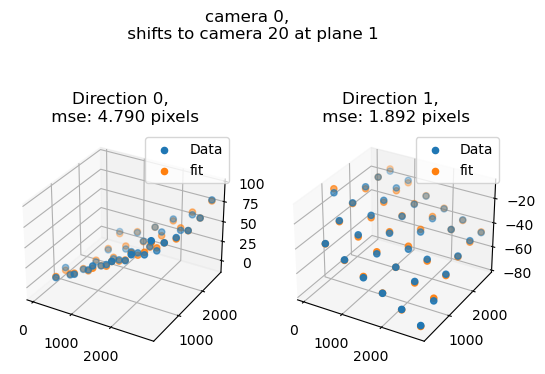

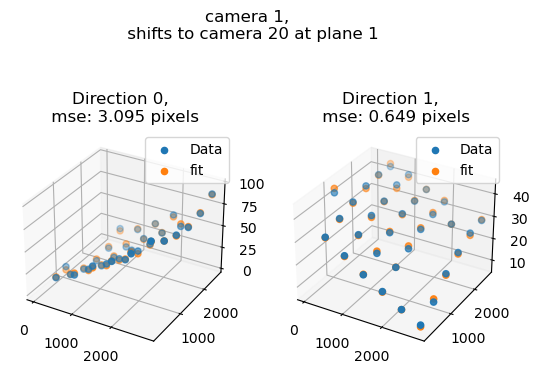

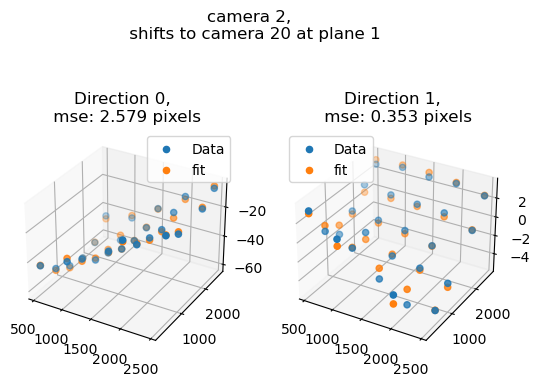

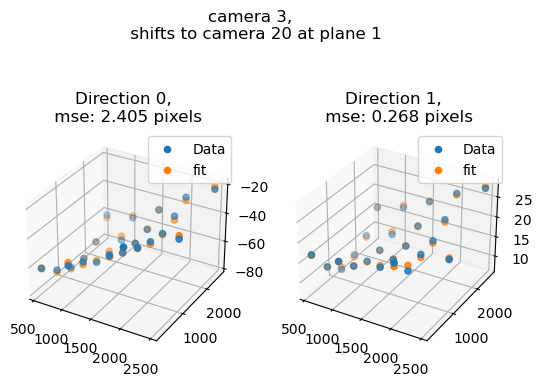

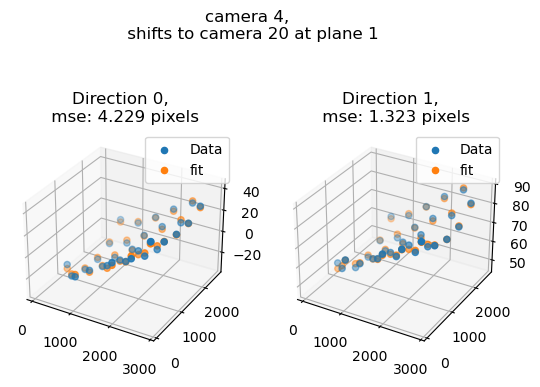

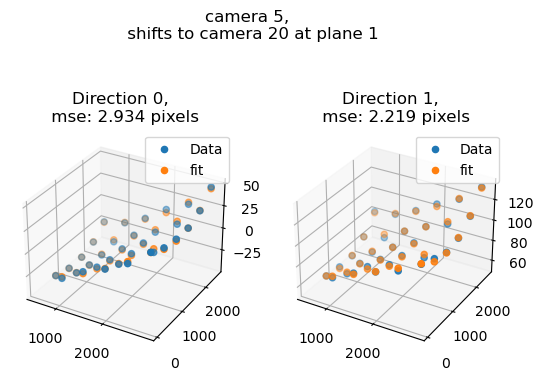

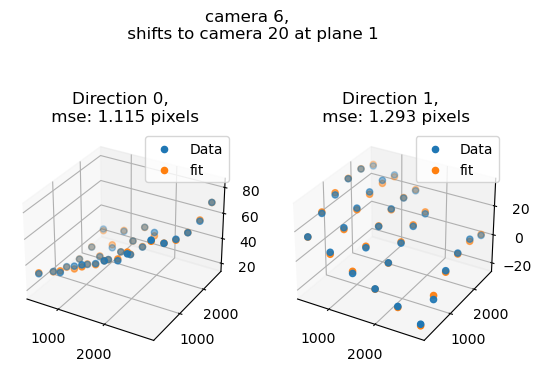

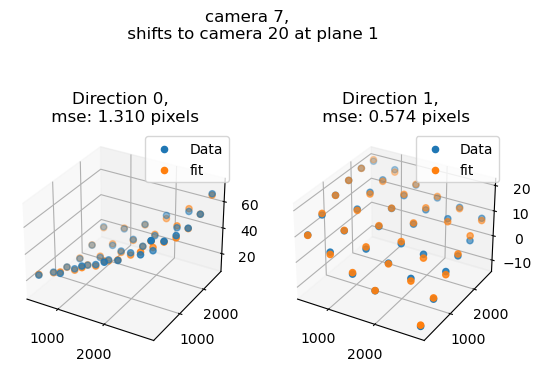

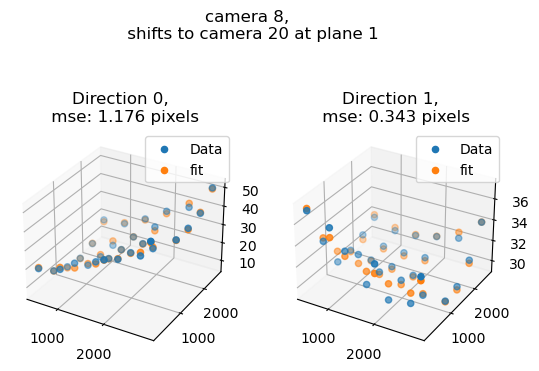

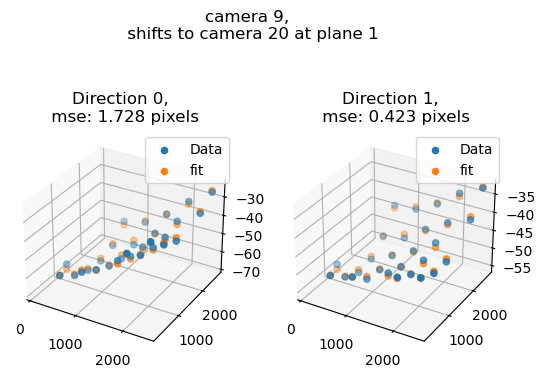

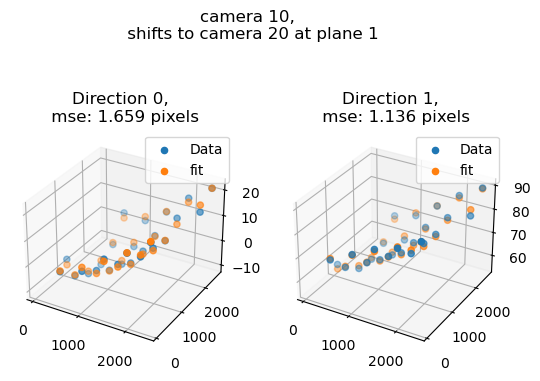

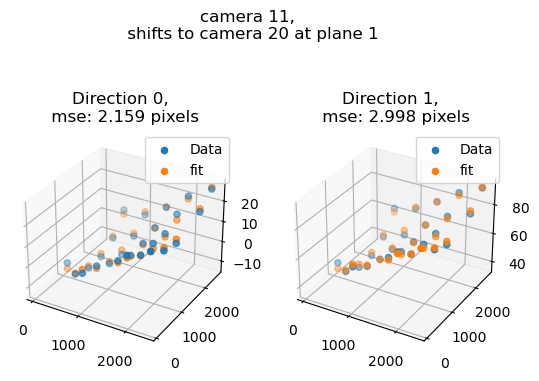

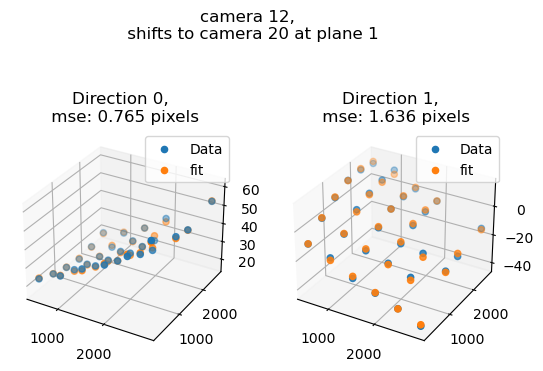

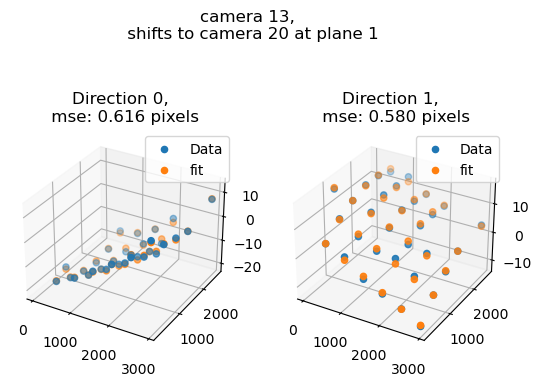

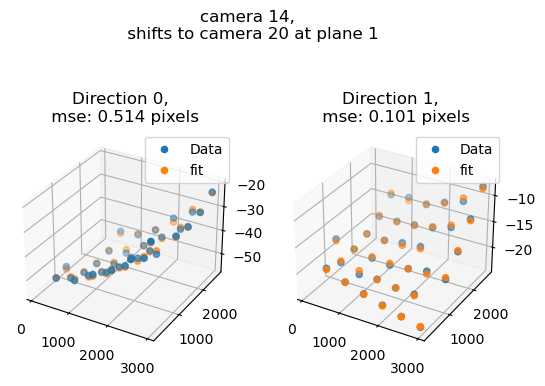

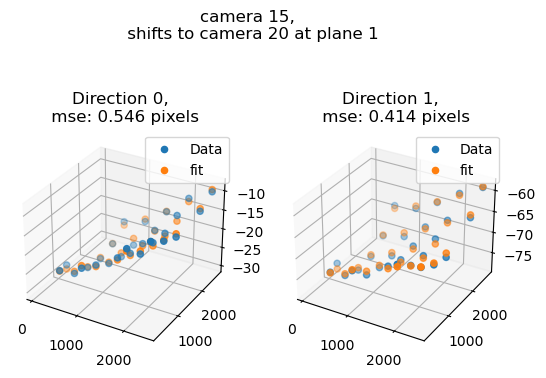

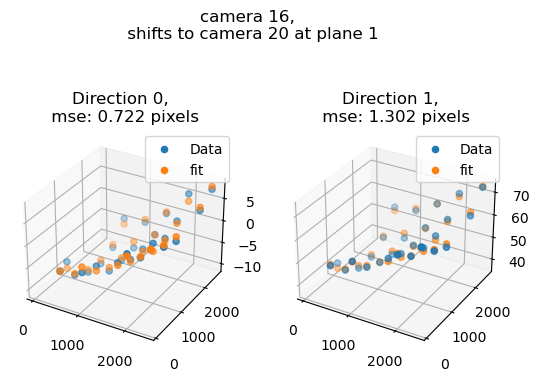

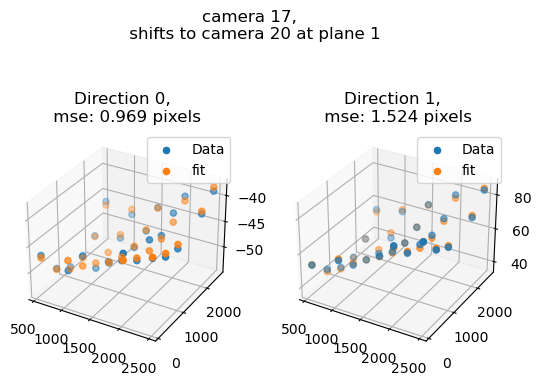

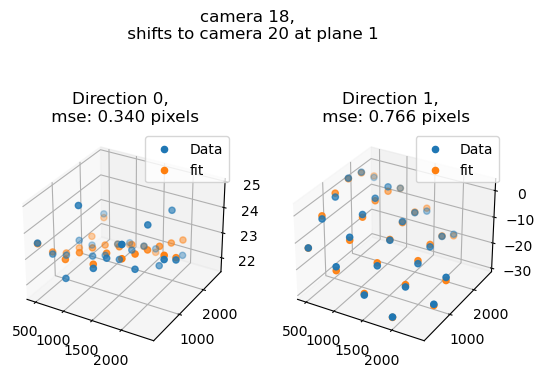

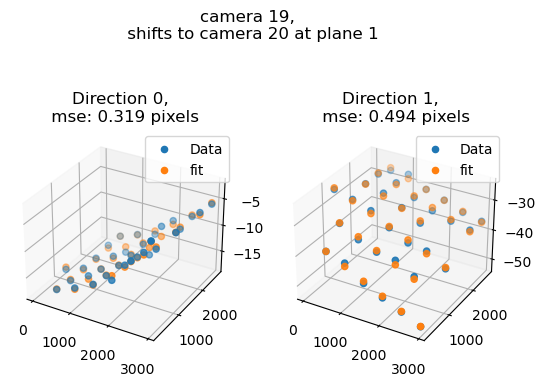

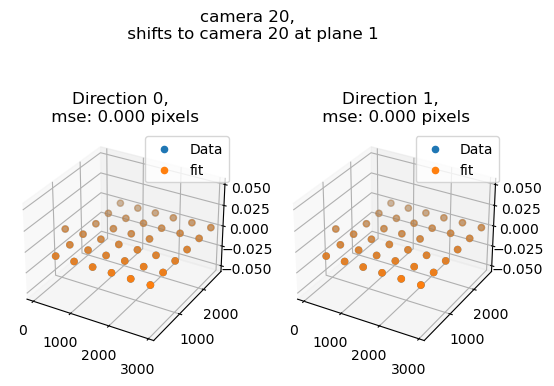

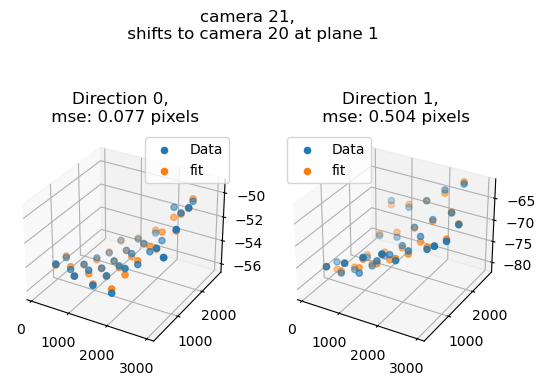

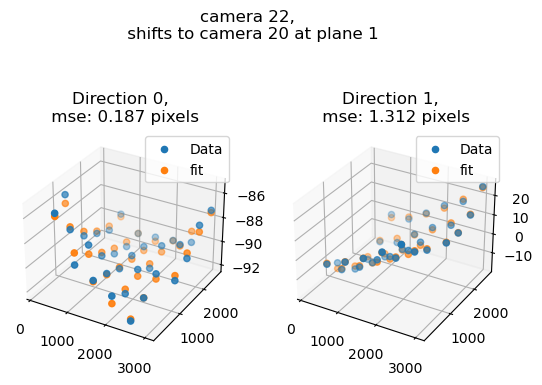

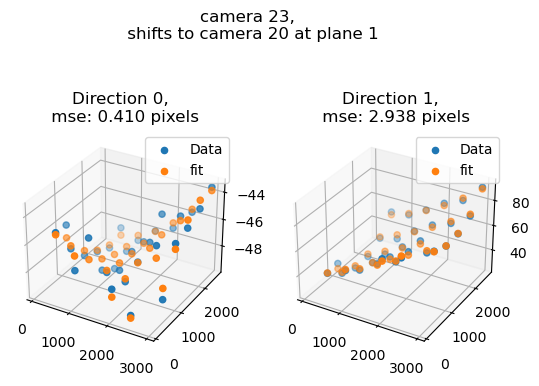

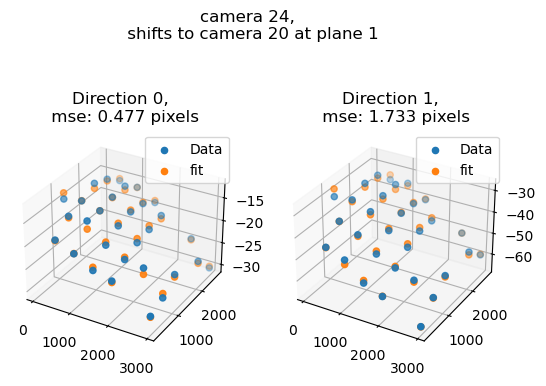

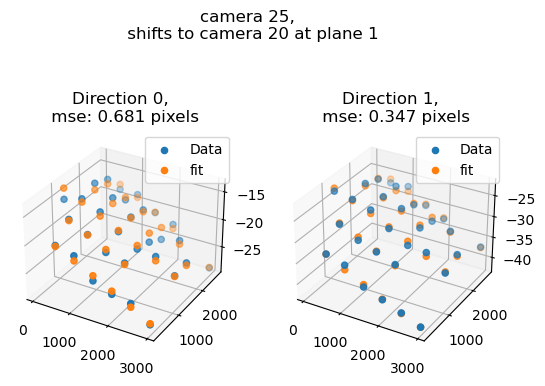

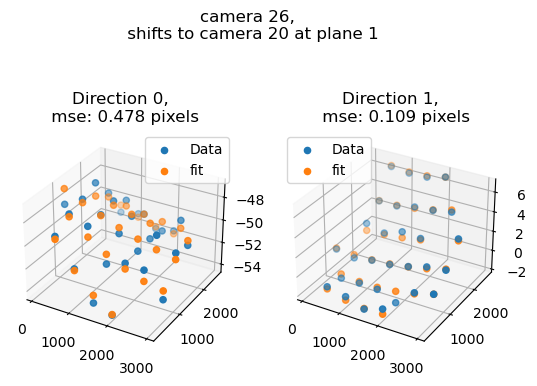

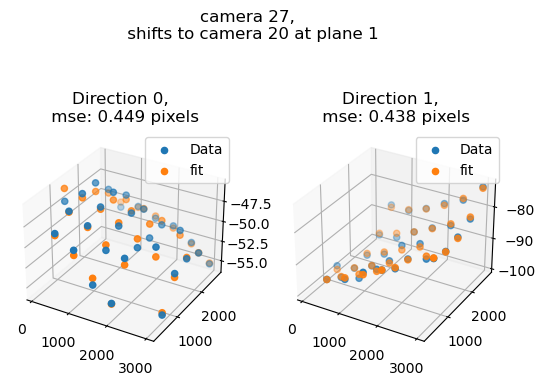

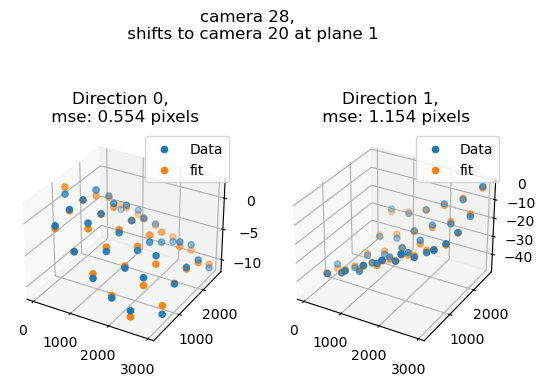

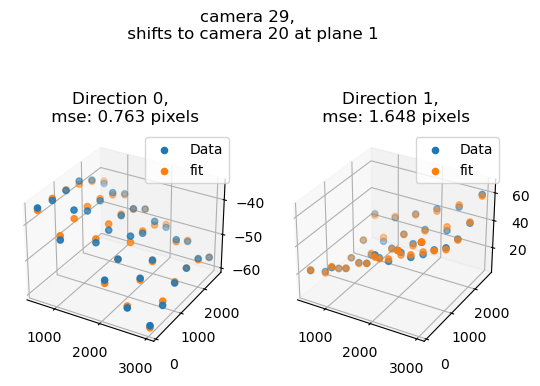

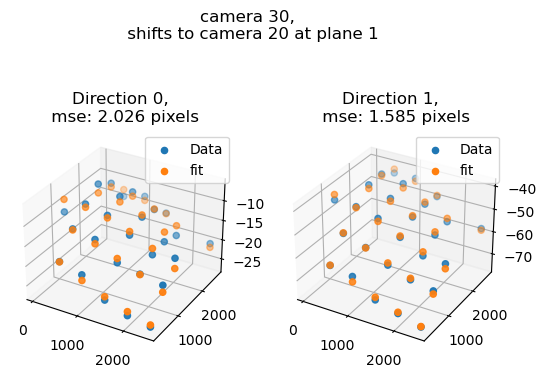

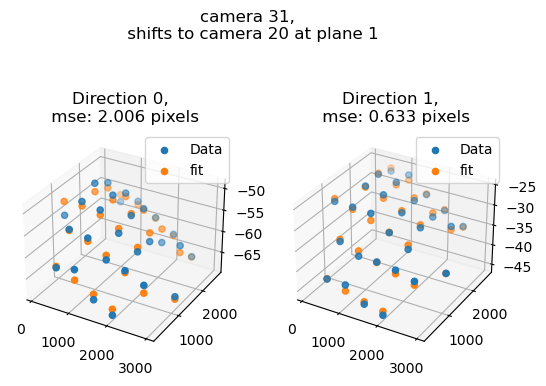

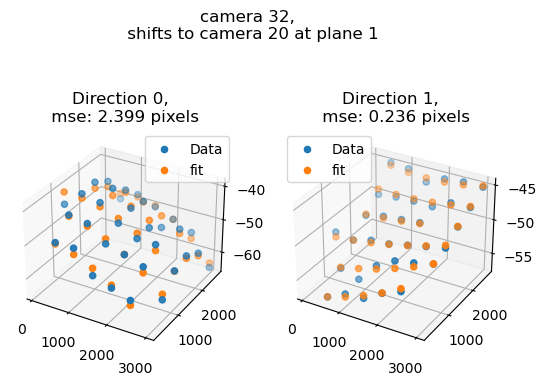

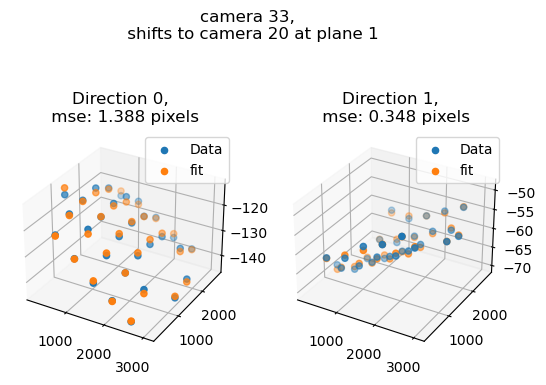

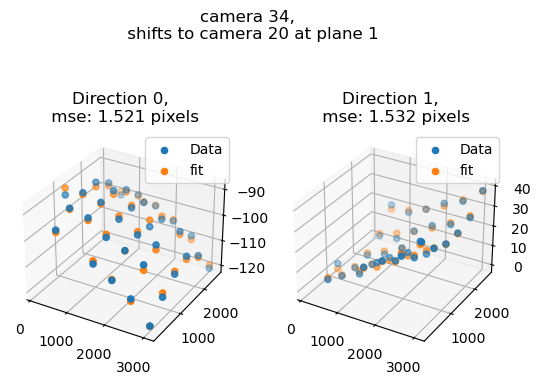

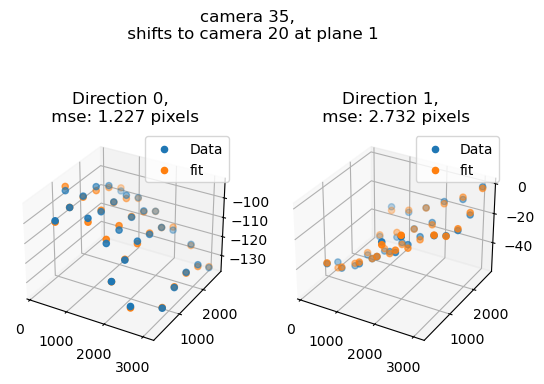

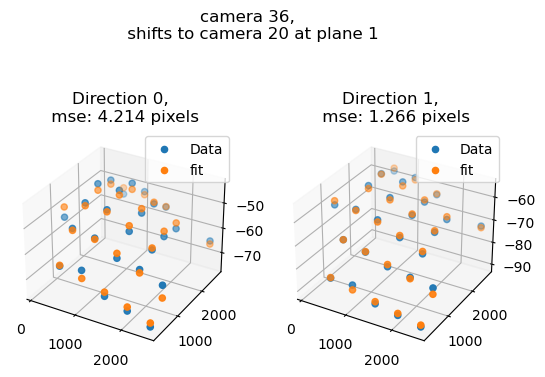

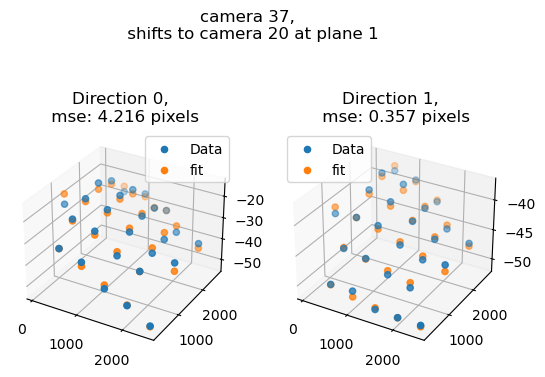

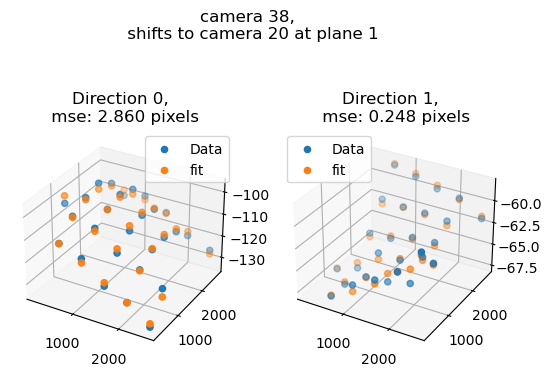

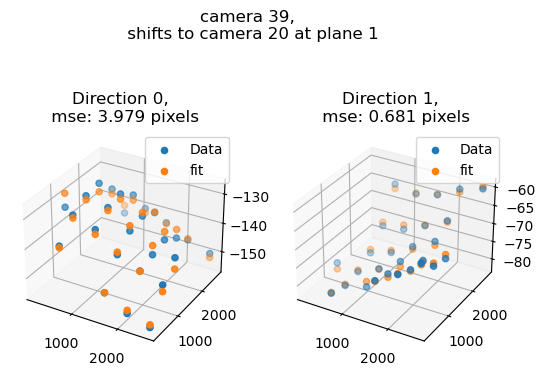

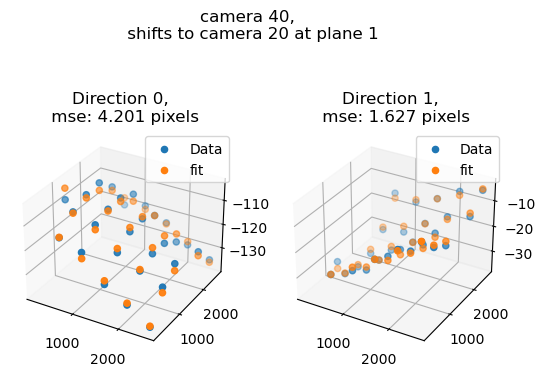

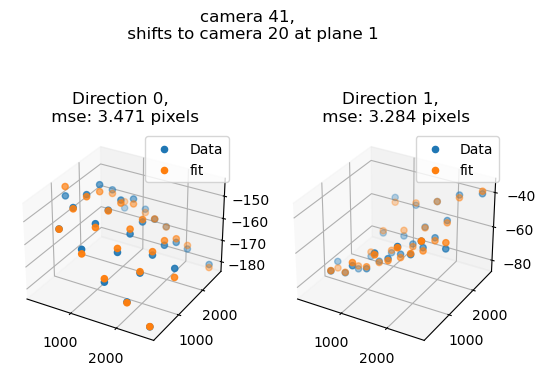

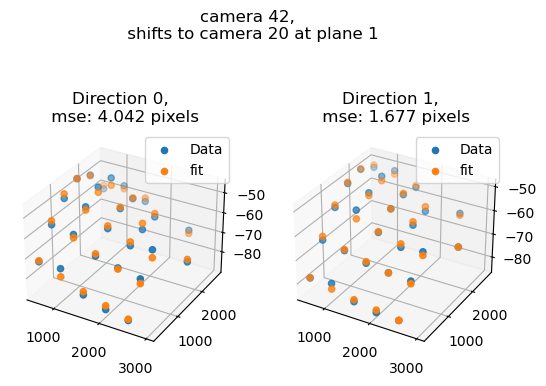

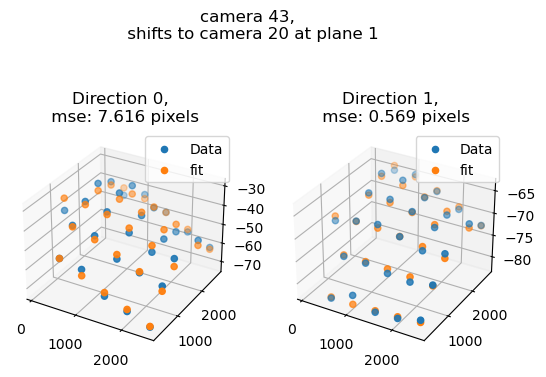

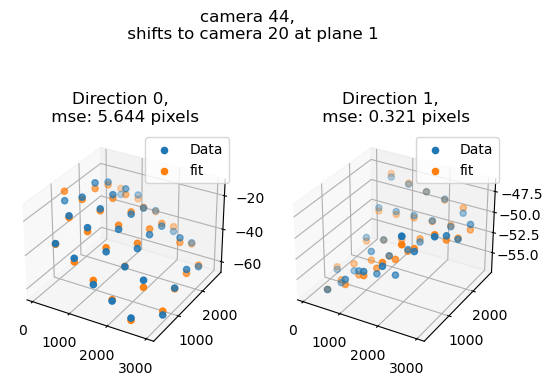

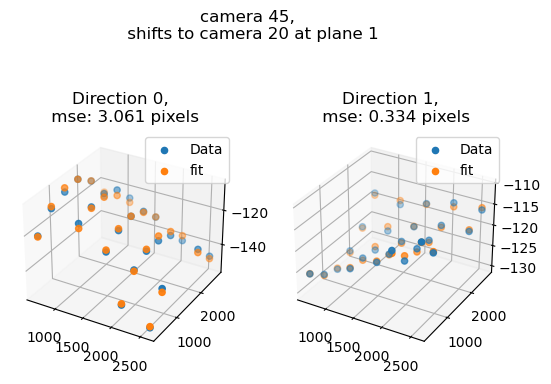

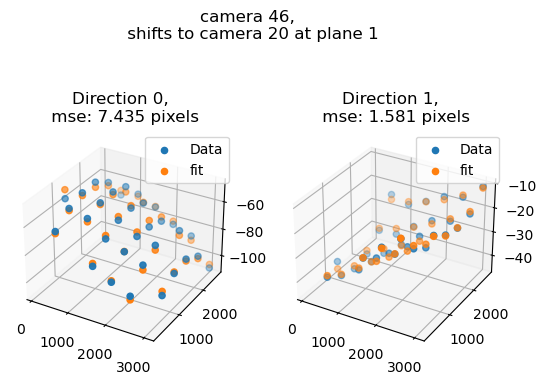

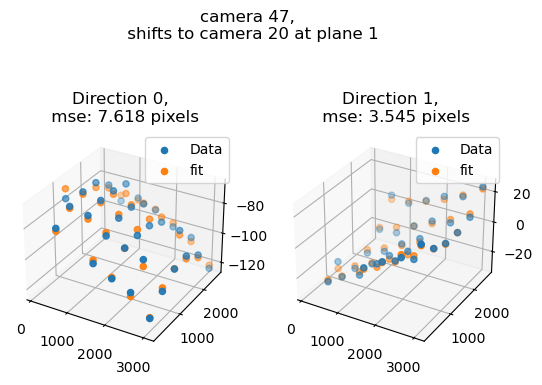

In [7]:
calibrator.run_inter_camera_calibration(show=True, order=2)

/home/clare/anaconda3/envs/filmscope2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/clare/anaconda3/envs/filmscope2/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/clare/git/FiLMScope/calibration/system_calibrator.py:295: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


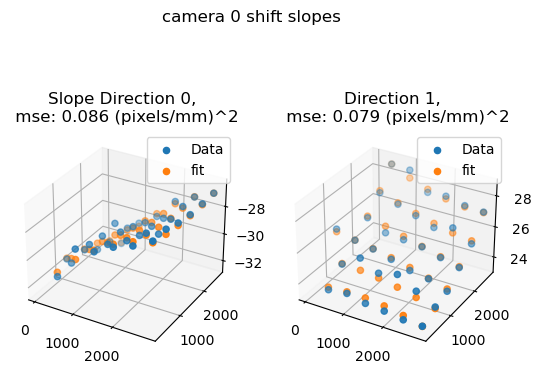

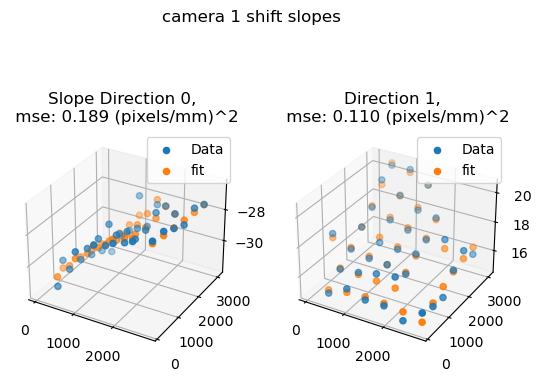

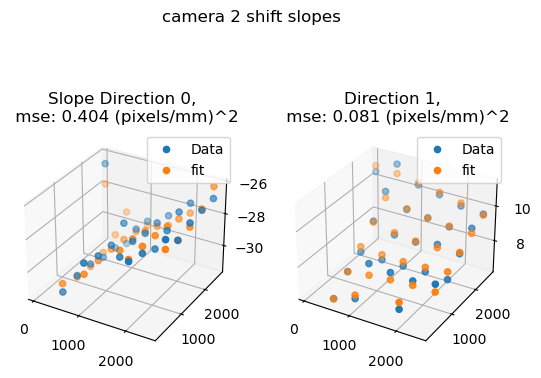

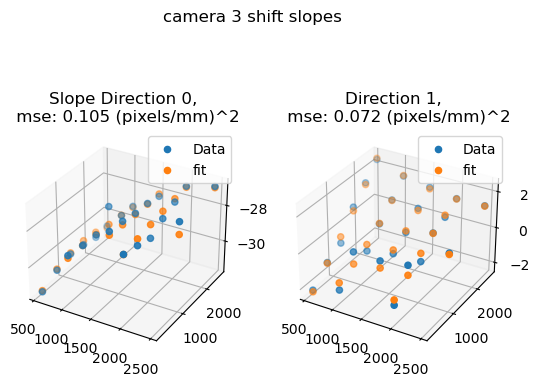

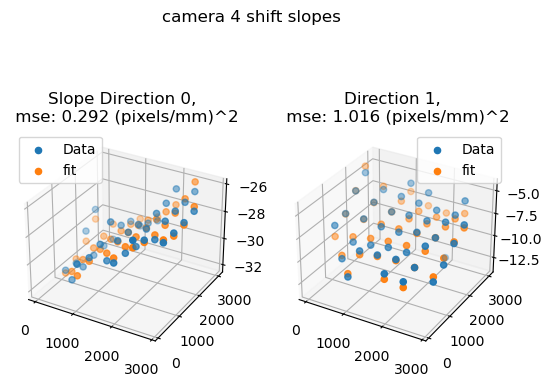

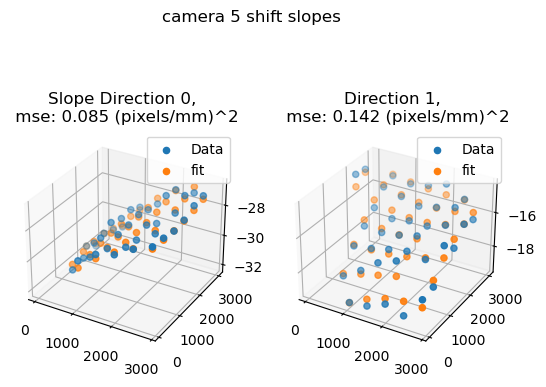

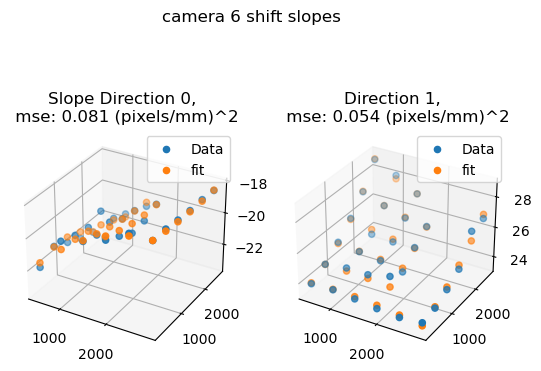

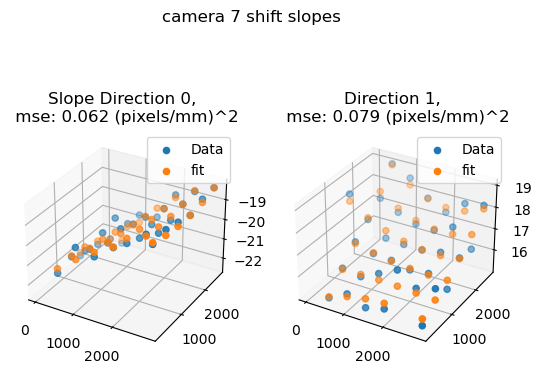

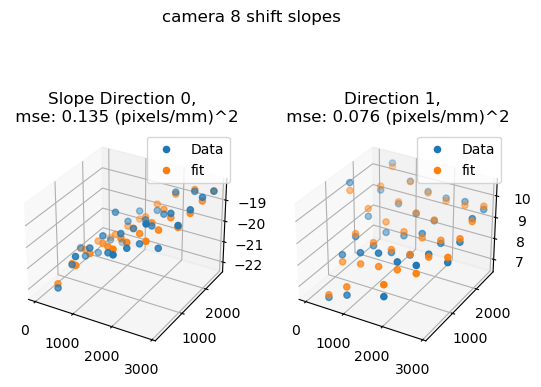

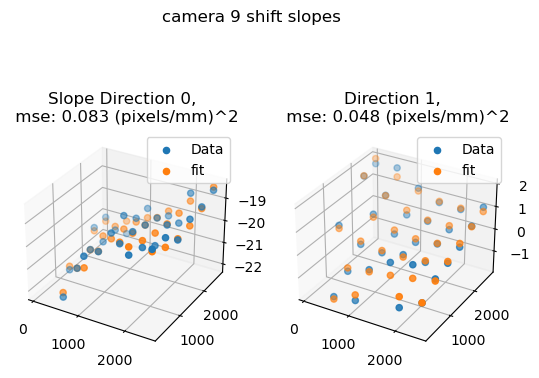

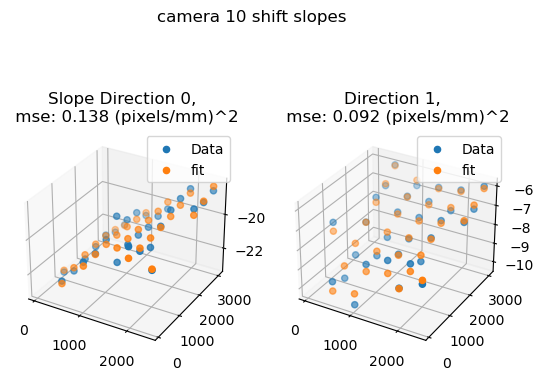

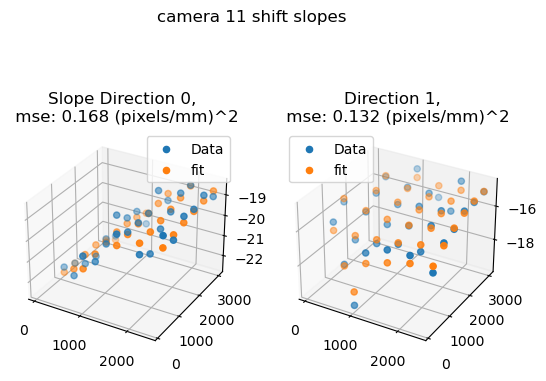

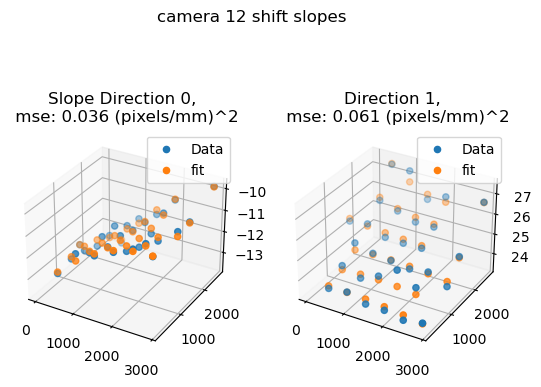

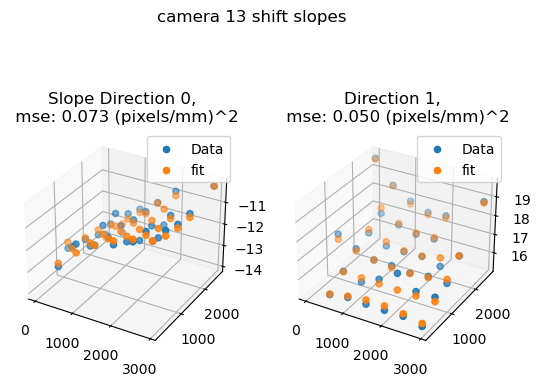

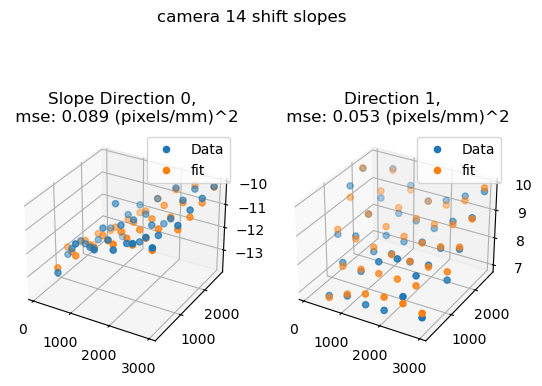

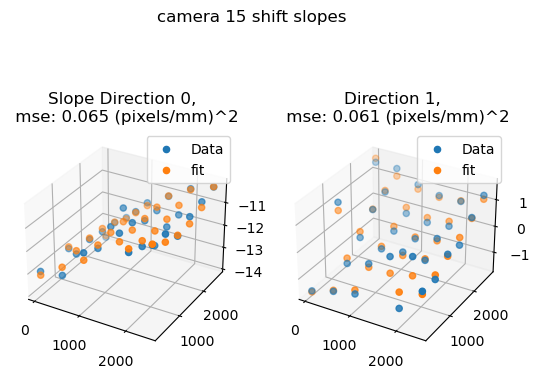

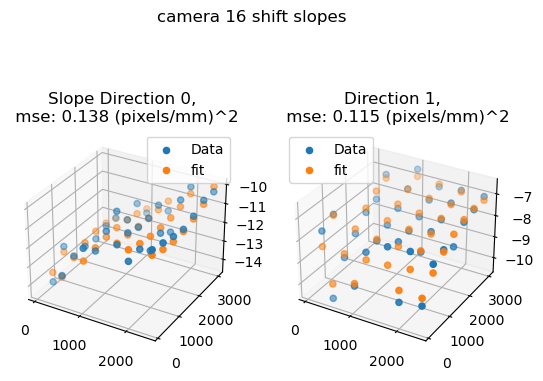

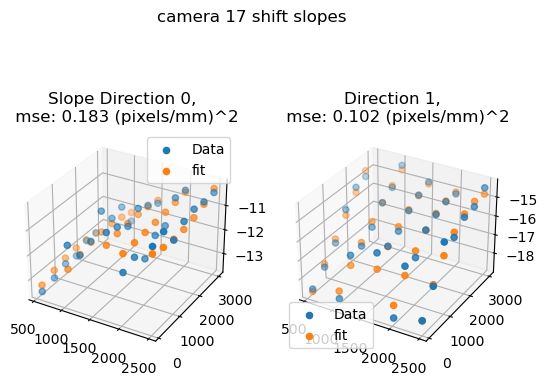

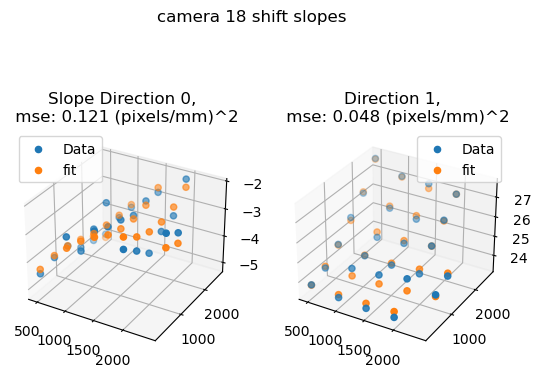

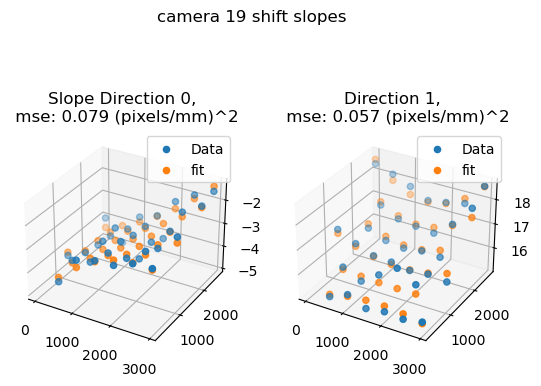

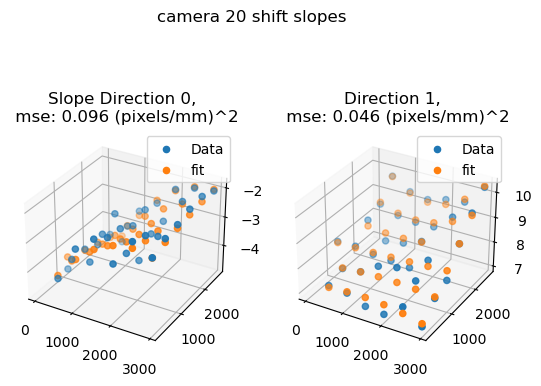

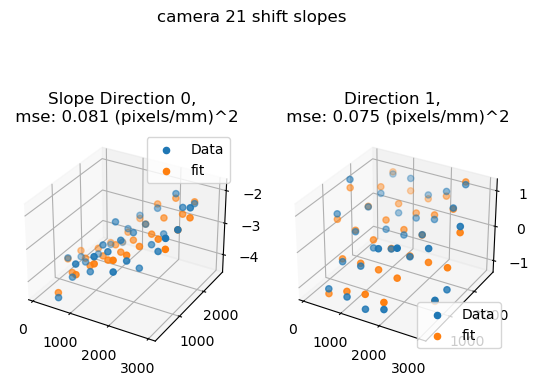

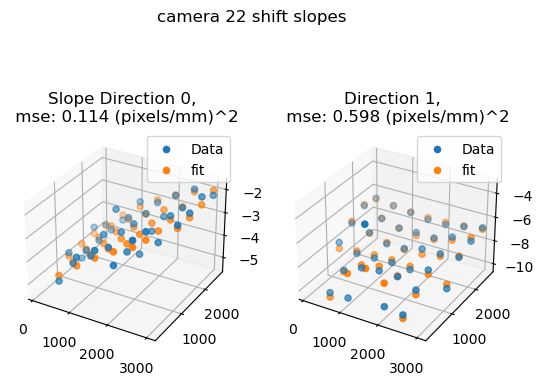

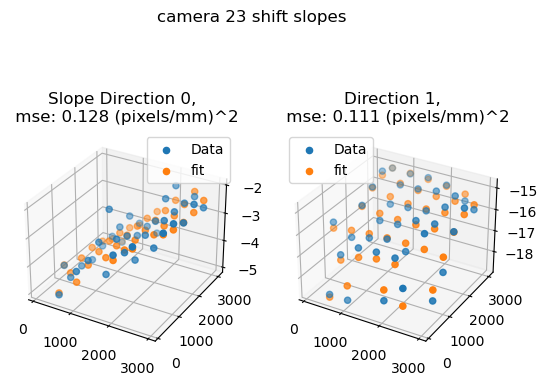

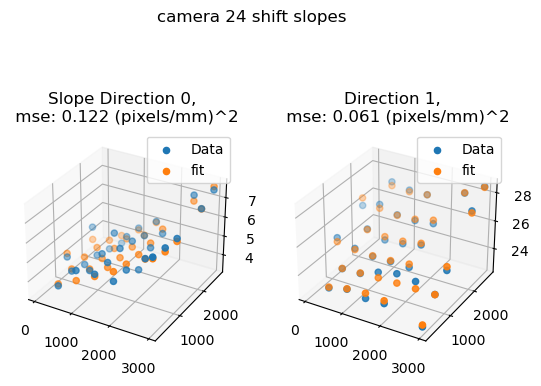

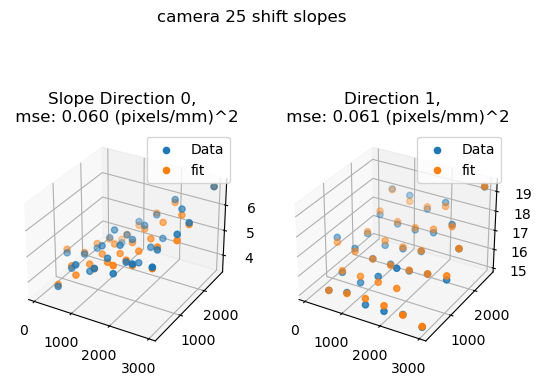

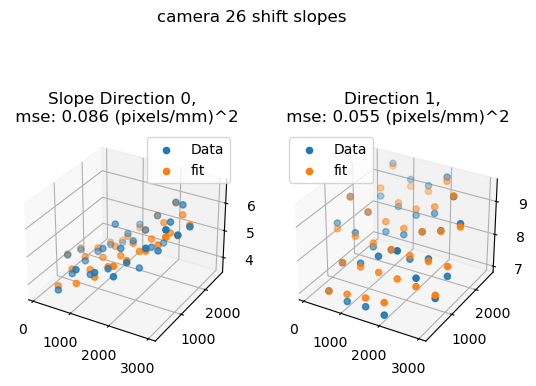

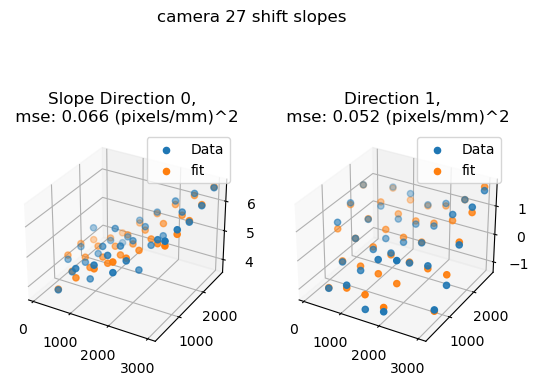

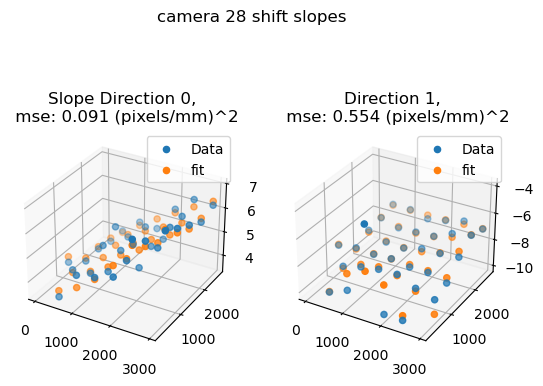

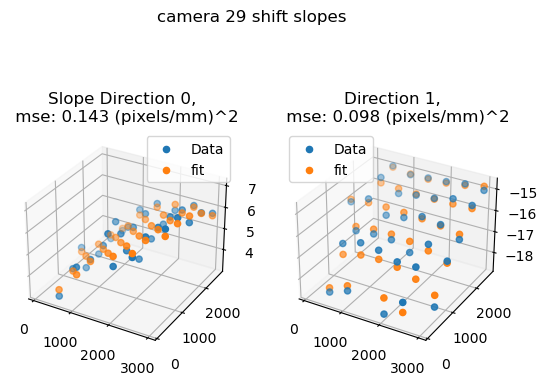

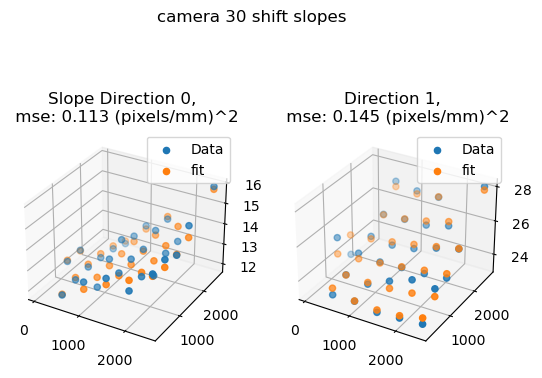

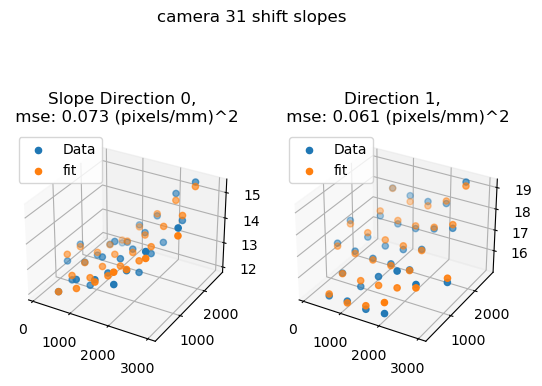

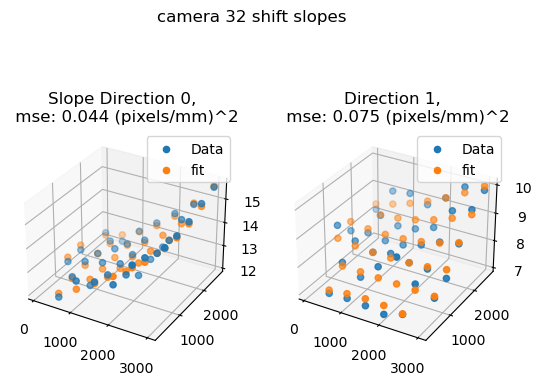

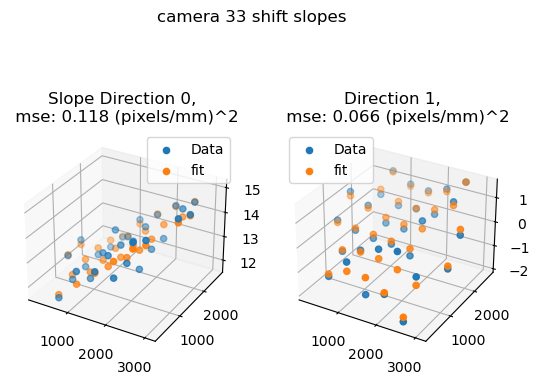

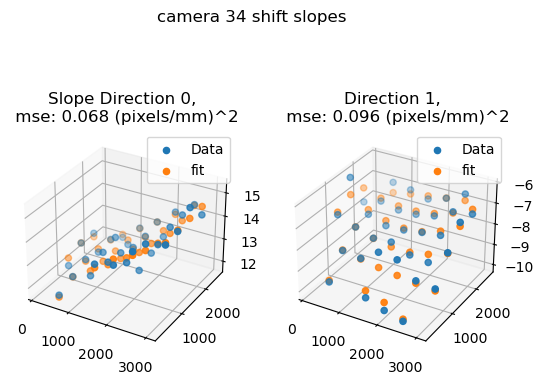

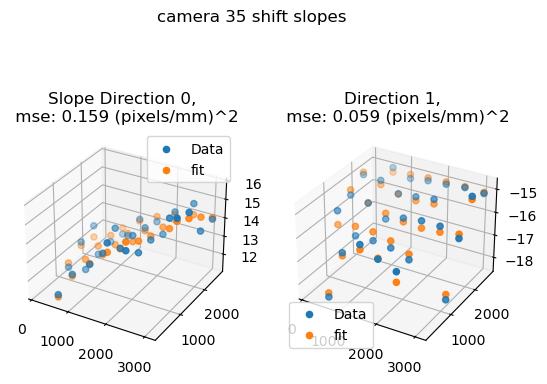

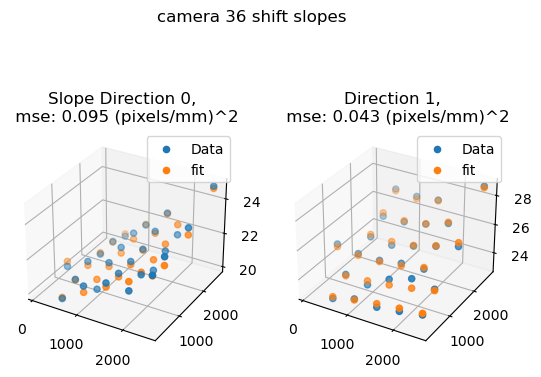

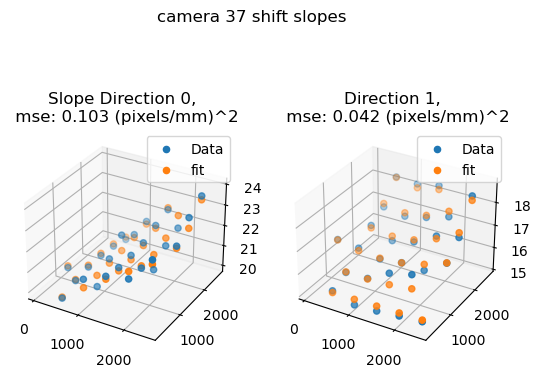

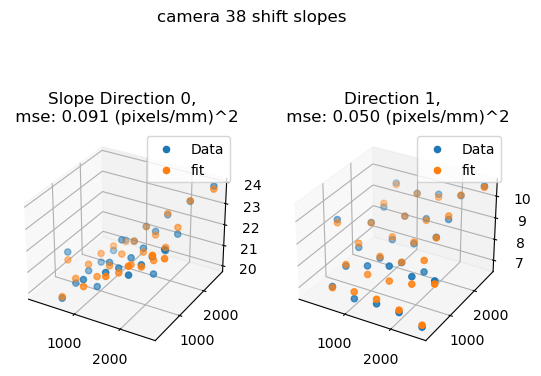

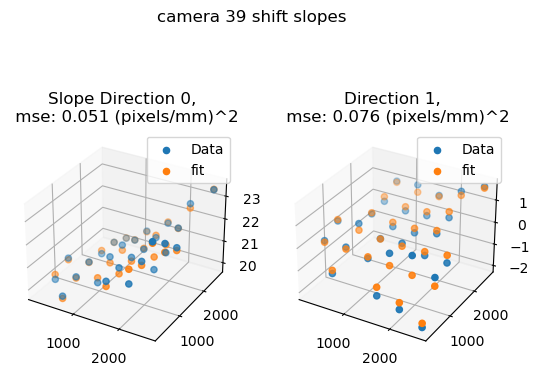

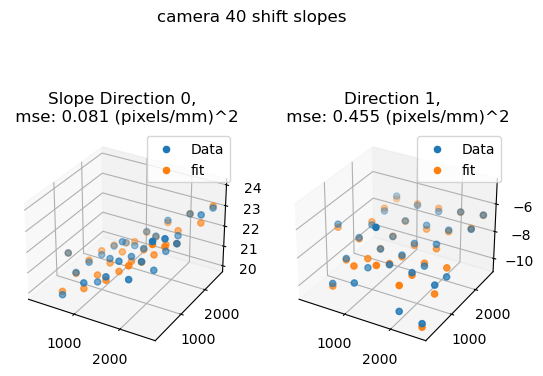

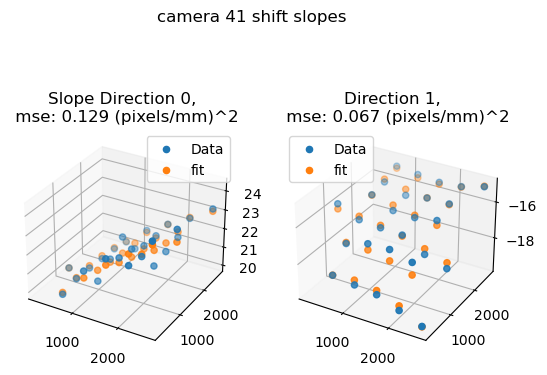

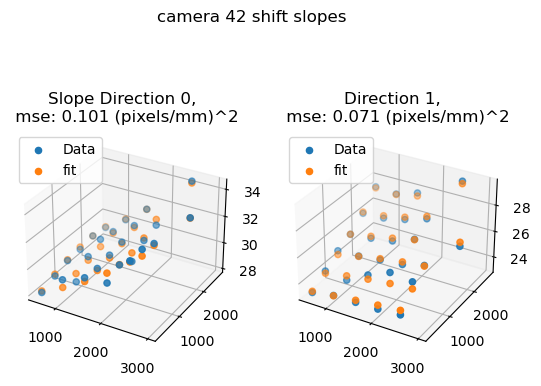

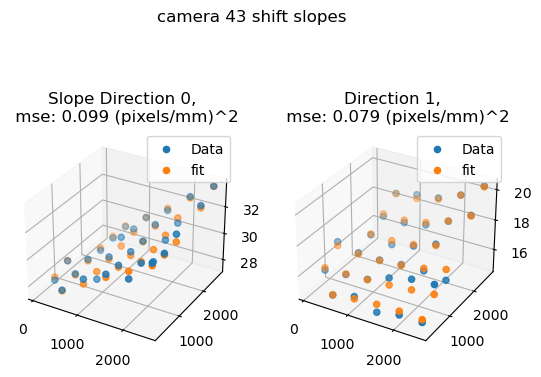

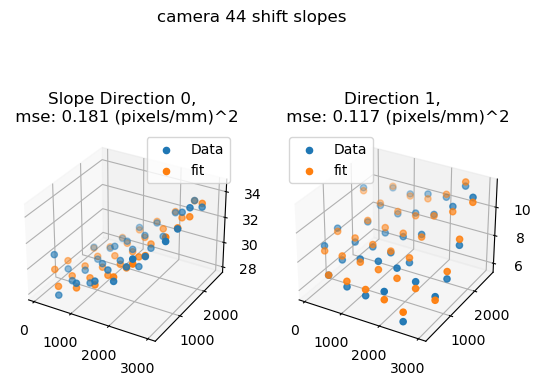

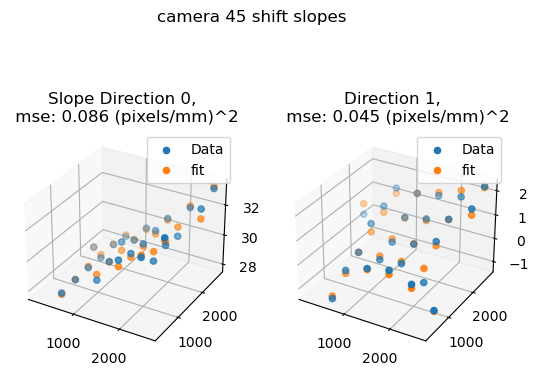

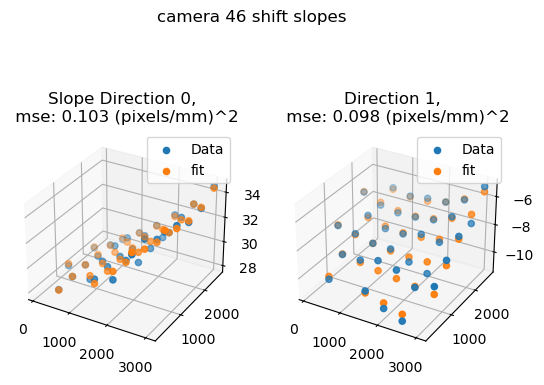

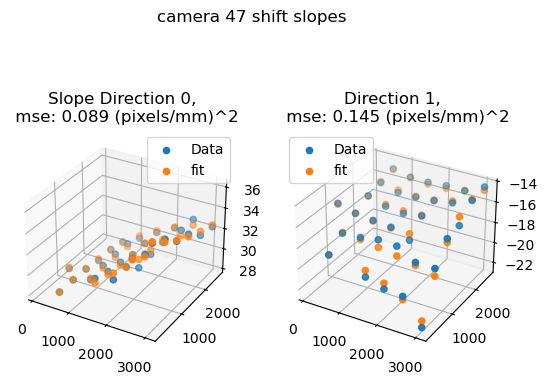

In [8]:
calibrator.run_slope_calibration(show=True, order=2)

Finally, check if results look reasonable

In [10]:
system = Filmscope_System(calibration_filename)
plane_separation_mm = system.calib_manager.plane_separation_mm
calibrator = SystemCalibrator(calibration_filename)
calibrator.get_all_camera_vertices_matrices()
all_camera_vertices_matrices = calibrator.all_camera_vertices_matrices

image_shape = system.calib_manager.image_shape

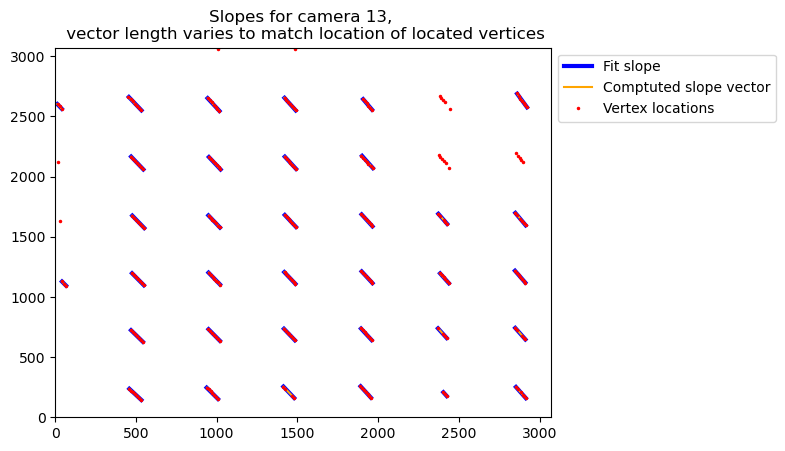

In [11]:
def make_comparison_plot(camera_number, vector_length_mm=None):
    slope0, slope1 = calibrator.get_slopes_from_vertices_matrices(camera_number)
    vertices_matrices = all_camera_vertices_matrices[camera_number]

    plt.figure()
    matrix_shape = vertices_matrices.shape[1:3]
    first = True
    for i, j in np.ndindex(matrix_shape):
        if first:
            label1 = "Comptuted slope vector"
            label2 = "Fit slope"
            label3 = "Vertex locations"
        else:
            label1 = None
            label2 = None
            label3 = None

        X = vertices_matrices[:, i, j, 0]
        Y = vertices_matrices[:, i, j, 1]

        if not np.isnan(slope0[i, j]):
            if vector_length_mm is None:
                start_plane_mm = (
                    np.where(~np.isnan(X))[0][0] - system.reference_plane
                ) * plane_separation_mm
                end_plane_mm = (
                    np.where(~np.isnan(X))[0][-1] - system.reference_plane
                ) * plane_separation_mm
            else:
                start_plane_mm = -vector_length_mm / 2
                end_plane_mm = vector_length_mm / 2

            x = vertices_matrices[system.reference_plane, i, j, 0]
            y = vertices_matrices[system.reference_plane, i, j, 1]

            # plot the slope vector that was fit to that point
            coeff0, coeff1 = system._get_slope_coeffs(camera_number)
            slope_matrix = generate_A_matrix(system.shift_order, [x], [y])
            v1 = np.matmul(slope_matrix, coeff0)[0]
            v0 = np.matmul(slope_matrix, coeff1)[0]
            x_start = x + v0 * start_plane_mm
            x_end = x + v0 * end_plane_mm
            y_start = y + v1 * start_plane_mm
            y_end = y + v1 * end_plane_mm
            plt.plot(
                [x_start, x, x_end],
                [y_start, y, y_end],
                "-",
                linewidth=3,
                color="blue",
                label=label2,
            )

            s0 = slope0[i, j]
            s1 = slope1[i, j]
            x_start = x + s0 * start_plane_mm / plane_separation_mm
            x_end = x + s0 * end_plane_mm / plane_separation_mm
            y_start = y + s1 * start_plane_mm / plane_separation_mm
            y_end = y + s1 * end_plane_mm / plane_separation_mm

            # plot the originally calculated slope vector
            plt.plot(
                [x_start, x, x_end],
                [y_start, y, y_end],
                "-",
                markersize=2,
                color="orange",
                label=label1,
            )

        if False in np.isnan(X):
            plt.plot(X, Y, ".", markersize=3, color="red", label=label3)
            first = False

    plt.legend(bbox_to_anchor=(1, 1))
    if vector_length_mm is not None:
        title = f"Slopes for camera {camera_number}, \n shown for {vector_length_mm} mm axial shift"
    else:
        title = f"Slopes for camera {camera_number}, \n vector length varies to match location of located vertices"
    plt.title(title)

    plt.xlim([0, image_shape[0]])
    plt.ylim([0, image_shape[1]])


make_comparison_plot(13, vector_length_mm=None)

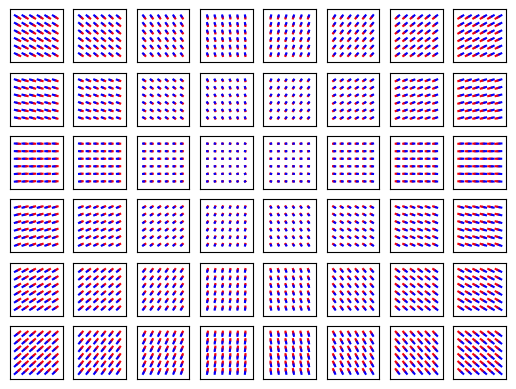

In [22]:
# Next plot: choose points in the image and plot lines that show how those points shift ?
# https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
def vector_plot(
    camera_number, vector_length_mm=10, ax=None, add_colorbar=True, add_title=True, s=50
):
    coeffs0, coeffs1 = system._get_slope_coeffs(camera_number)

    # pick locations in the image
    x_locs = np.linspace(0, image_shape[0], 8)[1:-1]
    y_locs = np.linspace(0, image_shape[1], 8)[1:-1]

    start_plane_mm = -vector_length_mm / 2
    end_plane_mm = vector_length_mm / 2

    # coloring array
    T = np.linspace(0, 1, s) ** 2

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    for x in x_locs:
        for y in y_locs:
            slope_matrix = generate_A_matrix(system.shift_order, [x], [y])
            v1 = np.matmul(slope_matrix, coeffs0)[0]
            v0 = np.matmul(slope_matrix, coeffs1)[0]

            x_start = x + v0 * start_plane_mm
            x_end = x + v0 * end_plane_mm
            y_start = y + v1 * start_plane_mm
            y_end = y + v1 * end_plane_mm

            # segment length
            s_x = (x_end - x_start) / s
            s_y = (y_end - y_start) / s

            colors = []
            for i in range(0, s):
                color = (1 - T[i], 0, T[i])
                colors.append(color)
                ax.plot(
                    [x_start + s_x * i, x_start + (s_x * (i + 1))],
                    [y_start + s_y * i, y_start + (s_y * (i + 1))],
                    color=color,
                )

    plt.xlim([0, image_shape[0]])
    plt.ylim([0, image_shape[1]])
    plt.gca().invert_yaxis()

    if add_colorbar:
        ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
        cmap = matplotlib.colors.ListedColormap(np.flip(np.asarray(colors), axis=1))
        norm = matplotlib.colors.Normalize(vmin=0, vmax=10)
        bounds = np.linspace(0, 20, 21)
        cb = matplotlib.colorbar.ColorbarBase(
            ax2, cmap=cmap, norm=norm, spacing="proportional", format="%1i"
        )

    if add_title:
        ax.set_title(f"Axial Shifts for Camera {camera_number}")
        ax.set_xlabel("Pixel Location (X)")
        ax.set_ylabel("Pixel Location (Y)")
    return ax

# showing all the vertices in each camera
fig, axes = plt.subplots(6, 8)
for camera_number in camera_numbers:
    ax_num0 = 5 - (camera_number % 6)
    ax_num1 = int(camera_number / 6)

    axis = axes[ax_num0, ax_num1]
    vector_plot(
        camera_number=camera_number,
        vector_length_mm=10,
        ax=axis,
        add_colorbar=False,
        add_title=False,
        s=3,
    )

    axis.set_xlim([0, image_shape[0]])
    axis.set_ylim([0, image_shape[1]])

    axis.set_xticks([])
    axis.set_yticks([])
    axis.invert_yaxis()
